Importar librerias necesarias

In [1]:
import pandas as pd
import nltk
import unicodedata
import re
import numpy as np
import gensim 

from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer 
from sklearn import cluster
from sklearn import metrics

import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('stopwords')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Lectura del archivo de transacciones en formato csv

In [2]:
nombres_columnas = ["id_trn_ach","id_cliente","fecha","hora","valor_trx","ref1","ref2","ref3","sector","subsector","descripcion","11","12","13"]

muestra = pd.read_csv('dt_trxpse_personas_2016_2018_muestra_adjt.csv', sep = ',', header = None, low_memory = False, names=nombres_columnas)

## Eliminar columnas
Las ultimas columnas creadas por el separador de coma ya que la ultima columna contenia dicho separador
la columna de referencia 3

In [3]:
muestra.drop('11', axis=1,inplace=True)
muestra.drop('12', axis=1,inplace=True)
muestra.drop('13', axis=1,inplace=True)
muestra.drop('ref2', axis=1,inplace=True)
muestra.drop('ref3', axis=1,inplace=True)

In [18]:
muestra.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion
0,230435642,3,20161207,113451,2122392.51,CC,NaN,NaN,NaN
1,222356110,10,20161016,3424,148438.37,Referencia: Contrato: Valor:,NaN,NaN,NaN
2,309137749,10,20180120,195042,94025.19,CC,NaN,NaN,NaN
3,324614737,10,20180326,192146,94430.07,CC,NaN,NaN,NaN
4,235344690,18,20170106,201317,670645.57,MEDICINA PREPAGADA COLSANITAS,NaN,NaN,NaN


In [6]:
muestra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11816281 entries, 0 to 11816280
Data columns (total 9 columns):
id_trn_ach     int64
id_cliente     int64
fecha          int64
hora           int64
valor_trx      float64
ref1           object
sector         object
subsector      object
descripcion    object
dtypes: float64(1), int64(4), object(4)
memory usage: 811.4+ MB


# Filtrar outliers

Se realiza este filtro con base a la desviación 3 veces hacia el limite superior, y en la información de la pagina de PSE la cual define transacciones validas de monto minimo: 1600 $, con este filtro queda aproximadamente el 98 % de la información

In [4]:
muestra = muestra[ (muestra['valor_trx'] > 1600 ) & (muestra['valor_trx'] < 3299021 )]

In [20]:
muestra.shape

(11634178, 9)

# Transformación de datos

Se converten columnas relacionadas con la referencia y el sector a tipo string para comenzar con las transformaciones

In [5]:
muestra['ref1'].fillna('sininfo', inplace = True)
muestra['sector'].fillna('sininfo', inplace = True)
muestra['subsector'].fillna('sininfo', inplace = True)
muestra['descripcion'].fillna('sininfo', inplace = True)

In [6]:
muestra['ref1'] = muestra['ref1'].astype('str')

muestra['sector'] = muestra['sector'].astype('str')
muestra['subsector'] = muestra['subsector'].astype('str')
muestra['descripcion'] = muestra['descripcion'].astype('str')

Convertir caracteres '+' y '_' en espacios

In [7]:
muestra['ref1'] = muestra['ref1'].str.replace('+',' ').str.replace('_',' ')
muestra['descripcion'] = muestra['descripcion'].str.replace('+',' ').str.replace('_',' ')

Quitar acentuaciones y pasar a ASCII - UTF8

In [9]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode('utf-8')

muestra['ref1'] = muestra['ref1'].apply(remove_accents)
muestra['descripcion'] = muestra['descripcion'].apply(remove_accents)
muestra['sector'] = muestra['sector'].apply(remove_accents)
muestra['subsector'] = muestra['subsector'].apply(remove_accents)

In [15]:
muestra.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion
0,230435642,3,20161207,113451,2122392.51,CC,sininfo,sininfo,sininfo
1,222356110,10,20161016,3424,148438.37,Referencia: Contrato: Valor:,sininfo,sininfo,sininfo
2,309137749,10,20180120,195042,94025.19,CC,sininfo,sininfo,sininfo
3,324614737,10,20180326,192146,94430.07,CC,sininfo,sininfo,sininfo
4,235344690,18,20170106,201317,670645.57,MEDICINA PREPAGADA COLSANITAS,sininfo,sininfo,sininfo


Dejar unicamente las cadenas de caracteres entre a-z, A-Z

In [10]:
muestra['ref1'] = muestra['ref1'].str.replace(r"[^a-zA-Z ]+", "").str.strip()
muestra['ref1'] = muestra['ref1'].str.replace(r"\W*\b\w{1,3}\b", "").str.strip()
muestra['descripcion'] = muestra['descripcion'].str.replace(r"[^a-zA-Z ]+", "").str.strip()

Pasar a minusculas

In [11]:
muestra['ref1'] = muestra['ref1'].str.lower()
muestra['sector'] = muestra['sector'].str.lower()
muestra['subsector'] = muestra['subsector'].str.lower()
muestra['descripcion'] = muestra['descripcion'].str.lower()

Eliminar stopwords

In [13]:
stop_aux = set(stopwords.words('spanish'))

stopwords_self=[]
for line in open('stop_words_self_2.csv'):
    stopwords_self += (line,)

d=[]
for  i in stopwords_self:
    doc=i.replace('\n',' ').strip()
    d.append(doc)
    
stop= stop_aux.union(d)

In [16]:
muestra['ref1'] = muestra['ref1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
muestra['sector'] = muestra['sector'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
muestra['descripcion'] = muestra['descripcion'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
muestra['subsector'] = muestra['subsector'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [15]:
muestra.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion
0,230435642,3,20161207,113451,2122392.51,,sininfo,sininfo,sininfo
1,222356110,10,20161016,3424,148438.37,referencia contrato valor,sininfo,sininfo,sininfo
2,309137749,10,20180120,195042,94025.19,,sininfo,sininfo,sininfo
3,324614737,10,20180326,192146,94430.07,,sininfo,sininfo,sininfo
4,235344690,18,20170106,201317,670645.57,medicina prepagada colsanitas,sininfo,sininfo,sininfo


Se eliminan todos los registros que no tienen descripcion valida en referencia

In [17]:
muestra = muestra[muestra['ref1'].str.len() > 0]
muestra.shape
#muestra.head()

(9446146, 9)

Se genera set de datos que no contiene informacion de sector, subsector y descripcion para realizar prediccion de clasificacion

In [18]:
muestra_target = muestra[muestra['sector'] == 'sininfo']
muestra_target.to_csv('muestra_target.csv', sep='|', encoding='utf-8')

Se lee un archivo generado por el equipo mediante el cual se dieron unas etiquetas o clasificaciones a algunos de los sectores y subsectores

In [20]:
nombres_columnas_label = ["sector","subsector","descripcion","categoria_pfm"]
etiqueta = pd.read_csv('Etiqueta.csv', sep = ';', low_memory = False)

Se concatenan los registros de transacciones con sector, subsector y descripcion con el archivo de labels para separar aquellos que no tienen un label target y generarlo por medio de clusterizacion

In [21]:
muestra_sector = muestra[muestra['sector'] != 'sininfo']

In [26]:
muestra_etiqueta = pd.merge(muestra_sector, etiqueta, how='left', on=['sector', 'subsector', 'descripcion'])
muestra_etiqueta.head()
muestra_etiqueta.shape

(2969291, 10)

Generar set de datos con sector y categoria para el clasificador

In [27]:
muestra_clasificador = muestra_etiqueta[muestra_etiqueta['categoria_pfm'].notnull()]
muestra_clasificador.shape

(2081259, 10)

In [214]:
muestra_clasificador.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion,categoria_pfm
11,319249942,45,20180305,111143,49520.98,presentacion impuest predial unific,gobierno,municipios,actividades ejecutivas administracion publica ...,pago de deudas
15,346095462,47,20180619,153159,125779.58,sald,medios comunicacion,telefonia fija,servicios telefonia fija,tecnologia y comunicaciones
16,228320905,49,20161125,130737,75313.50,referent express,medios comunicacion,valor agregado,actividades telecomunicaciones inalambricas,tecnologia y comunicaciones
17,249117129,49,20170327,83646,82913.43,referent express,medios comunicacion,valor agregado,actividades telecomunicaciones inalambricas,tecnologia y comunicaciones
18,278487871,49,20170829,102756,67414.37,referent express,medios comunicacion,valor agregado,actividades telecomunicaciones inalambricas,tecnologia y comunicaciones


Generar set de datos que contienen informacion de sector, subsector y descripcion

In [20]:
muestra_sector.shape

(2969291, 10)

Generar set de datos con sector, subsector y descripcion pero que al cruzar con las etiquetas creadas quedo sin etiqueta, para generar clusterizacion por la informacion de la referencia

In [30]:
muestra_cluster = muestra_etiqueta[muestra_etiqueta['categoria_pfm'].isnull()]

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion,categoria_pfm
0,241307506,19,20170210,142809,701067.98,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN
1,285847659,40,20171003,151703,192491.73,factura asociado,servicios financieros,bancos,bancos comerciales,NaN
3,335337578,45,20180507,145248,431146.54,edif mirabell,servicios financieros,bancos,bancos comerciales,NaN
4,365833134,45,20180903,160242,264895.19,edif mirabell,servicios financieros,bancos,bancos comerciales,NaN
11,275818562,55,20170814,102457,1519060.05,factura asociado,servicios financieros,bancos,bancos comerciales,NaN


In [31]:
muestra_cluster['stem'] = muestra_cluster.ref1.str.split(' ')

stemmer = SnowballStemmer('spanish')
muestra_cluster['stem2'] = muestra_cluster['stem'].apply(lambda x: [stemmer.stem(y) for y in x])

muestra_cluster['stem3'] = muestra_cluster['stem2'].apply(lambda x: ' '.join(map(str,x)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [33]:
#muestra_cluster.shape
muestra_cluster.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion,categoria_pfm,stem,stem2,stem3
0,241307506,19,20170210,142809,701067.98,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti
1,285847659,40,20171003,151703,192491.73,factura asociado,servicios financieros,bancos,bancos comerciales,NaN,"[factura, asociado]","[factur, asoci]",factur asoci
3,335337578,45,20180507,145248,431146.54,edif mirabell,servicios financieros,bancos,bancos comerciales,NaN,"[edif, mirabell]","[edif, mirabell]",edif mirabell
4,365833134,45,20180903,160242,264895.19,edif mirabell,servicios financieros,bancos,bancos comerciales,NaN,"[edif, mirabell]","[edif, mirabell]",edif mirabell
11,275818562,55,20170814,102457,1519060.05,factura asociado,servicios financieros,bancos,bancos comerciales,NaN,"[factura, asociado]","[factur, asoci]",factur asoci


## Clusterizacion
Para este tema se decide trabjar con k-means, ya que es un algoritmo deterministico, simple de implementar y en general funciona bien.
Nuestros datos serán el conjunto de frases que contiene el campo de ref1, este campo debe quedar en una lista de listas de oraciones tokenizadas por palabras.

En esta parte se clusterizaran los sectores, subsectores y descripcion que no se encontraron con una etiqueta valida.

Se vuelve el campo referencia una lista de oraciones

In [34]:
campo_cluster=list(set(muestra_cluster['stem3']))

Se tokenizan las oraciones para que la frase quede como una lista de palabras.

In [35]:
sentences = [z.split(' ') for z in campo_cluster]
sentences[10]

['sandr', 'milen', 'idarragaroj']

A cada frase se le asigna un vector de numeros reales (inscrustaciones de palabras)

In [36]:
model = Word2Vec(sentences, min_count=1)

# Pasar del nivel de palabra al nivel de oración

Para cada oración del conjunto de frases

In [37]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw


X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))
 
print ("========================")
X[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


array([-4.0615657e-03, -3.5153548e-03,  1.9421277e-03, -4.5870477e-03,
       -3.6053848e-03,  2.1307894e-03,  4.1170735e-03,  2.2587732e-03,
       -2.5612048e-03,  4.0336032e-03, -3.1040311e-03, -4.4158157e-03,
       -2.5812941e-04,  3.7322021e-03, -1.8804775e-03, -1.4909713e-03,
        1.7163982e-03,  2.0066029e-03,  4.6155814e-04,  4.3784184e-03,
        2.2370582e-03,  3.9523626e-03, -3.7607825e-03,  4.7048326e-03,
       -1.3580935e-03, -1.3884024e-03,  1.5567620e-03,  1.3202998e-03,
        4.0647970e-03,  2.1649629e-03,  3.8794097e-03, -3.2645448e-03,
        3.0569602e-03, -9.3273201e-04,  1.5773536e-03,  3.2364798e-03,
        2.7230612e-03, -9.9430536e-04,  3.5913642e-03,  1.7923579e-03,
       -4.3137809e-03, -1.5268085e-04, -2.0651906e-03,  1.3600462e-03,
        3.8728663e-03,  4.7645685e-03,  6.2114786e-04, -1.2775550e-04,
        4.2400643e-05,  3.2526592e-03,  6.5552146e-04, -4.6777070e-04,
        3.0508945e-03,  3.3355420e-03, -4.5117810e-03, -2.0961061e-03,
      

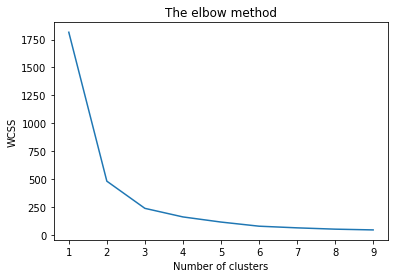

In [38]:
import matplotlib.pyplot as plt

#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 10), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [39]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
#print (assigned_clusters)

In [40]:
s=[]
for index, sentence in enumerate(sentences):    
    s.append(str(assigned_clusters[index]) + str(sentence))

In [41]:
df_cluster = pd.DataFrame(data=s, columns = ['cluster_frase'])

In [42]:
df_cluster.head()

,cluster_frase
0,2['premex']
1,"0['mal', 'praxis']"
2,"0['asistent', 'medic']"
3,"0['pensin', 'transport', 'abrilequitacin']"
4,2['pagoabrilymay']


In [44]:
df_cluster['cluster']= df_cluster['cluster_frase'].str[0]
df_cluster['frase']= df_cluster['cluster_frase'].str[1:]
df_cluster.head()

,cluster_frase,cluster,frase
0,2['premex'],2,['premex']
1,"0['mal', 'praxis']",0,"['mal', 'praxis']"
2,"0['asistent', 'medic']",0,"['asistent', 'medic']"
3,"0['pensin', 'transport', 'abrilequitacin']",0,"['pensin', 'transport', 'abrilequitacin']"
4,2['pagoabrilymay'],2,['pagoabrilymay']


In [146]:
#df_cluster.to_csv('cluster_buenos_stem.csv', sep='|', index = None, encoding='utf-8')

In [45]:
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[0 0 1 ... 1 2 1]
Centroids data
[[ 0.02320175  0.00359388  0.02406441  0.0132644  -0.02867831 -0.00444175
   0.01759452  0.00834232 -0.02584915 -0.01526175  0.03333687  0.01506057
  -0.03169145  0.01758192  0.01761992 -0.02446303  0.01933446 -0.02313769
  -0.00870785 -0.00900547 -0.00392228 -0.0018878  -0.00898437 -0.03503165
  -0.01367053  0.00161646  0.0093681   0.00476304  0.00299605  0.01761719
   0.00635213  0.00203113 -0.01073088 -0.01465826  0.00961377 -0.00365026
   0.01678026 -0.01084366  0.01128379  0.00547044 -0.00593545 -0.0259597
   0.00784527 -0.01093144 -0.01041988 -0.02336159 -0.02895549  0.02024352
  -0.02260288  0.00830094  0.01320798 -0.00420449 -0.0129013   0.0169053
   0.00519023 -0.01754446 -0.00696436 -0.01365944  0.01036782  0.00783784
   0.01782151  0.00061746 -0.0125193   0.01977672  0.0257087   0.00370994
  -0.00827763  0.02352901  0.02209482  0.01756277  0.00065469 -0.01791017
  -0.01989221  0.01281645 -0.01670037  0.0207

In [46]:
df_cluster['stem3'] = df_cluster['frase'].str.replace("'",'').str.replace(',','').str.replace('[','').str.replace(']','')
df_cluster.head()

,cluster_frase,cluster,frase,stem3
0,2['premex'],2,['premex'],premex
1,"0['mal', 'praxis']",0,"['mal', 'praxis']",mal praxis
2,"0['asistent', 'medic']",0,"['asistent', 'medic']",asistent medic
3,"0['pensin', 'transport', 'abrilequitacin']",0,"['pensin', 'transport', 'abrilequitacin']",pensin transport abrilequitacin
4,2['pagoabrilymay'],2,['pagoabrilymay'],pagoabrilymay


In [47]:
muestra_cluster.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion,categoria_pfm,stem,stem2,stem3
0,241307506,19,20170210,142809,701067.98,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti
1,285847659,40,20171003,151703,192491.73,factura asociado,servicios financieros,bancos,bancos comerciales,NaN,"[factura, asociado]","[factur, asoci]",factur asoci
3,335337578,45,20180507,145248,431146.54,edif mirabell,servicios financieros,bancos,bancos comerciales,NaN,"[edif, mirabell]","[edif, mirabell]",edif mirabell
4,365833134,45,20180903,160242,264895.19,edif mirabell,servicios financieros,bancos,bancos comerciales,NaN,"[edif, mirabell]","[edif, mirabell]",edif mirabell
11,275818562,55,20170814,102457,1519060.05,factura asociado,servicios financieros,bancos,bancos comerciales,NaN,"[factura, asociado]","[factur, asoci]",factur asoci


In [48]:
muestra_cluster_final = pd.merge(muestra_cluster, df_cluster, how='inner', on=['stem3'])

In [49]:
muestra_cluster_final.shape

(888032, 16)

In [50]:
muestra_cluster_final['cluster'] = muestra_cluster_final['cluster'].str.replace('0','pago de deudas').str.replace('1','tecnologia y comunicaciones').str.replace('2','otros')
muestra_cluster_final.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion,categoria_pfm,stem,stem2,stem3,cluster_frase,cluster,frase
0,241307506,19,20170210,142809,701067.98,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti,"0['planill', 'cesanti']",pago de deudas,"['planill', 'cesanti']"
1,314524981,4569,20180213,194533,2451650.30,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti,"0['planill', 'cesanti']",pago de deudas,"['planill', 'cesanti']"
2,314282053,7979,20180213,90750,985222.15,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti,"0['planill', 'cesanti']",pago de deudas,"['planill', 'cesanti']"
3,313980468,8516,20180212,93503,2119422.06,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti,"0['planill', 'cesanti']",pago de deudas,"['planill', 'cesanti']"
4,313525497,9350,20180209,100659,623897.82,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,NaN,"[planilla, cesantias]","[planill, cesanti]",planill cesanti,"0['planill', 'cesanti']",pago de deudas,"['planill', 'cesanti']"


In [51]:
muestra_cluster_final = muestra_cluster_final.drop('stem', 1)
muestra_cluster_final = muestra_cluster_final.drop('stem2', 1)
muestra_cluster_final = muestra_cluster_final.drop('stem3', 1)
muestra_cluster_final = muestra_cluster_final.drop('cluster_frase', 1)
muestra_cluster_final = muestra_cluster_final.drop('frase', 1)
muestra_cluster_final = muestra_cluster_final.drop('categoria_pfm', 1)

In [52]:
muestra_cluster_final = muestra_cluster_final.rename(columns={'cluster': 'categoria_pfm'})
muestra_cluster_final.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,sector,subsector,descripcion,categoria_pfm
0,241307506,19,20170210,142809,701067.98,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,pago de deudas
1,314524981,4569,20180213,194533,2451650.30,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,pago de deudas
2,314282053,7979,20180213,90750,985222.15,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,pago de deudas
3,313980468,8516,20180212,93503,2119422.06,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,pago de deudas
4,313525497,9350,20180209,100659,623897.82,planilla cesantias,servicios financieros,servicios financieros,actividades auxiliares actividades servicios f...,pago de deudas


In [53]:
muestra_clasificador_final = pd.concat([muestra_cluster_final, muestra_clasificador])

In [54]:
#muestra_clasificador_final.head(100)
muestra_clasificador_final.shape

(2969291, 10)

Exportar archivo completo de clasificacion uniendo las clasificaciones generadas por la etiqueta y los datos clusterizados

In [51]:
muestra_clasificador_final.to_csv('muestra_clasificador.csv', sep='|', index = None, encoding='utf-8')